In [1]:
import time
import numpy as np
import pandas as pd
import sys
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
sys.path.append('/home/sebastian/Documents/PhD/pyprojects/')
sys.path.append('/home/sebastian/Documents/PhD/pyprojects/Modality/')

from Modality.TomatoExtension import TomatoExtension
from ScaleSpace.ScaleSpace import ScaleSpaceTree
from NoiseRemoval.ClusterGMM import gmm_cut


# Import data

In [4]:
fname = 'cluster_data_uppersco_extravel_covmtx.csv'
data = pd.read_csv(fname)

In [20]:
data_axes = ['X', 'Y', 'Z', 'v_alpha', 'v_delta']
pos_cols = ['X', 'Y', 'Z']
c_pos, c_vel = 1, 5   # See infos on scaling in Kerr+2021 (https://arxiv.org/pdf/2105.09338.pdf)

df_cluster = data[data_axes]
df_cluster[['v_alpha', 'v_delta']] *= c_vel

/home/sebastian/anaconda3/envs/my_root_env/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Graph and mid point preparation

In [25]:
%%time
max_knn = 70
#te = TomatoExtension(df_cluster, max_neighbors=100, beta=0.99, knn_cluster_graph=50, knn_hypotest=20, knn_max=max_knn)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs


In [26]:
%%time
te.update(knn_hypotest=20, knn_cluster_graph=40)
res = te.fit(alpha=0.05)

CPU times: user 35.4 s, sys: 93.2 ms, total: 35.5 s
Wall time: 8.99 s


In [27]:
# Clusters
np.unique(res, return_counts=True)

(array([  0,   7,  10,  16,  25,  31,  33,  35,  36,  39,  41,  47,  50,
         51,  54,  57,  58,  60,  61,  64,  66,  68,  73,  77,  78,  83,
         88,  93,  95,  96, 101, 103, 104, 109, 110, 112, 113, 114, 116,
        131, 136, 142]),
 array([ 663,  741, 1181,   92,  722,  162, 5169, 2298,  204,  625,  351,
        3193,  271,  562,  147,  576,  312,  928, 1631,  998, 3750, 2369,
         382,  238,  150,   78, 2973,  820, 2801,  408, 2070,  531, 1683,
        1063,  743, 1817,  397, 1148,  628,  211,  211, 1196]))

## Remove noise in new setting

In [28]:
from sklearn.neighbors import kneighbors_graph

ajm_knn = kneighbors_graph(df_cluster, n_neighbors=10, include_self=True, n_jobs=-1)

In [ ]:
clustering_res = -np.ones(data.shape[0])

for uid in np.unique(res):
    print(f'Removing noise from cluster {uid}')
    ba, good_cluster = remove_noise_tomatoext(
        data=df_cluster,
        cluster_bool_arr=res == uid, 
        te_obj=te, 
        pos_cols=pos_cols,
        nb_neigh_denstiy=10,
        data_full=data, 
        ra_col='ra', dec_col='dec', plx_col='parallax', pmra_col='pmra', pmdec_col='pmdec',
        rv_col='dr2_radial_velocity', rv_err_col='dr2_radial_velocity_error', uvw_cols=['u', 'v', 'w'],
        adjacency_mtrx=ajm_knn, 
        radius=8,
        min_cluster_size=10
    )
    if good_cluster:
        clustering_res[ba] = uid
        print(f'{np.sum(ba)} part of cluster')
        print(f'{30 * "-"}')

Removing noise from cluster 0
Step 1: Reduction to dense cores
Step 2: Computing optimal velocity
Step 3: Finding dense regions in XYZ-UVW
24 part of cluster
------------------------------
Removing noise from cluster 7
Step 1: Reduction to dense cores
Step 2: Computing optimal velocity
Step 3: Finding dense regions in XYZ-UVW
Removing noise from cluster 10
Step 1: Reduction to dense cores
Step 2: Computing optimal velocity
Step 3: Finding dense regions in XYZ-UVW
64 part of cluster
------------------------------
Removing noise from cluster 16
Step 1: Reduction to dense cores
Step 2: Computing optimal velocity
Step 3: Finding dense regions in XYZ-UVW
16 part of cluster
------------------------------
Removing noise from cluster 25
Step 1: Reduction to dense cores
Step 2: Computing optimal velocity


# Plot clusters

In [19]:
cs = clustering_res  #fc_noise_removed  # cs_renamed
df_plot = data.loc[cs!=-1].reset_index(drop=True)
clustering_solution = cs.astype(int)
clustering_solution = clustering_solution[clustering_solution!=-1]
cut_us = np.random.uniform(0,1,size=clustering_solution.shape[0])<0.1


bg_opacity = 0.1
bg_color = 'grey'
plt_colors = [
    '#636EFA',
    '#EF553B',
    '#00CC96',
    '#AB63FA',
    '#FFA15A',
    '#19D3F3',
    '#FF6692',
    '#B6E880',
    '#FF97FF',
    '#FECB52',
    '#B82E2E',
    '#316395'
]


# Create figure
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "xy"}, {"type": "xy"}]],
    column_widths=[0.5, 0.3, 0.2],
    subplot_titles=[
        'Galactic position', 
        'Tangential velocity', 
        'HRD'
    ],

)

# --------------- 3D scatter plot -------------------
trace_3d_bg = go.Scatter3d(
    x=df_plot.loc[cut_us, 'X'], y=df_plot.loc[cut_us, 'Y'], z=df_plot.loc[cut_us, 'Z'],
    mode='markers',
    marker=dict(size=1, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False,
)
fig.add_trace(trace_3d_bg, row=1, col=1)

trace_sun = go.Scatter3d(
    x=np.zeros(1), y=np.zeros(1), z=np.zeros(1),
    mode='markers',
    marker=dict(size=5, color='red',
                symbol='x'
               ),
    hoverinfo='none',
    showlegend=True,
    name='Sun'
)

fig.add_trace(trace_sun, row=1, col=1)

# trace_hrd_isochrone = go.Scatter(
#     x=coords[:,0], y=coords[:,1],
#     mode='lines',
#     marker=dict(line_width=0.5, color='black',
#                 opacity=0.3
#                ),
#     hoverinfo='none',
#     showlegend=True,
#     name='50 My'
# )
# fig.add_trace(trace_hrd_isochrone, row=1, col=3)




for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_3d = go.Scatter3d(
            x=df_plot.loc[plot_points, 'X'], y=df_plot.loc[plot_points, 'Y'], z=df_plot.loc[plot_points, 'Z'],
            mode='markers',
            marker=dict(size=1, color=plt_colors[i%len(plt_colors)]),
            hoverinfo='none',
            showlegend=True,
            name=f'Cluster {int(uid)} ({np.sum(plot_points)} stars)',
            legendgroup=f'group-{uid}',
        )
        fig.add_trace(trace_3d, row=1, col=1)
# --------------- 2D vel plot -------------------
trace_vel_bg = go.Scatter(
    x=df_plot.loc[cut_us, 'v_alpha'], y=df_plot.loc[cut_us, 'v_delta'],
    mode='markers',
    marker=dict(size=3, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False
)
fig.add_trace(trace_vel_bg, row=1, col=2)

for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_vel = go.Scatter(
            x=df_plot.loc[plot_points, 'v_alpha'], y=df_plot.loc[plot_points, 'v_delta'],
            mode='markers',
            marker=dict(size=3, color=plt_colors[i%len(plt_colors)], 
                     #colorscale='inferno',
                     #opacity=,
                    ),
            hoverinfo='none',
            legendgroup=f'group-{uid}',
            name=f'Cluster {uid} ({np.sum(plot_points)} stars)',
            showlegend=False
        )
        fig.add_trace(trace_vel, row=1, col=2)


# --------------- HRD plot -------------------
trace_hrd_bg = go.Scatter(
    x=df_plot.loc[cut_us, 'g_rp'], y=df_plot.loc[cut_us, 'mag_abs_g'],
    mode='markers',
    marker=dict(size=3, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False
)
fig.add_trace(trace_hrd_bg, row=1, col=3)

for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_hrd = go.Scatter(
            x=df_plot.loc[plot_points, 'g_rp'], y=df_plot.loc[plot_points, 'mag_abs_g'],
            mode='markers',
            marker=dict(size=3, color=plt_colors[i%len(plt_colors)], 
                     #colorscale='inferno',
                     #opacity=,
                    ),
            hoverinfo='none',
            legendgroup=f'group-{uid}',
            name=f'Cluster {uid} ({np.sum(plot_points)} stars)',
            showlegend=False
        )
        fig.add_trace(trace_hrd, row=1, col=3)



# ------------ Update axis information ---------------
# 3d position
plt_kwargs = dict(showbackground=False, showline=False, zeroline=True, zerolinecolor='grey', zerolinewidth=2, 
                  showgrid=True, showticklabels=True, 
                  linecolor='black', linewidth=1,  gridcolor='rgba(100,100,100,0.5)')

xaxis=dict(**plt_kwargs, title='X [pc]') #, tickmode = 'linear', dtick = 50, range=[-50,200])
yaxis=dict(**plt_kwargs, title='Y [pc]') #, tickmode = 'linear', dtick = 50, range=[-200, 50])
zaxis=dict(**plt_kwargs, title='Z [pc]') #, tickmode = 'linear', dtick = 50, range=[-100, 150])
# tangential vel
fig.update_xaxes(title_text="v_alpha", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="v_delta", showgrid=False, row=1, col=2)
# tangential vel
fig.update_xaxes(title_text="G-RP", showgrid=False, row=1, col=3)
fig.update_yaxes(title_text="Abs mag G", showgrid=False, autorange="reversed", row=1, col=3)


# Finalize layout
fig.update_layout(
    title="",
    #width=800,
    height=800,
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend= dict(itemsizing='constant'),
    # 3D plot
    scene=dict(
        xaxis=dict(xaxis),
        yaxis=dict(yaxis),
        zaxis=dict(zaxis)
    )
)


fig.write_html(f"tomato_ext_latest_plot.html")

# Construct scale space

In [10]:
sst = ScaleSpaceTree(data_size=data.shape[0], min_jaccard_sim=0.5)

alpha = 0.01
data_idx = np.arange(data.shape[0])
knn_densities_ssp = np.arange(10,100,2)

for i, nb_neighs in enumerate(knn_densities_ssp):
    st = time.time()
    print(f'Number of neighbors: {nb_neighs}', end=' ')
    # Add level to scale space
    te.update(nb_neighs)
    res = te.fit(alpha=alpha)
    modes = {uid: data_idx[res==uid][np.argmax(te.t.weights_[res==uid])] for uid in np.unique(res)}
    part = {modes[uid]: data_idx[res==uid] for uid in np.unique(res)}
    sst.next_scale(partitions=part)
    print(f'- level {i} took {time.time()-st:.2f} sec')

Number of neighbors: 10 level 0 took 33.89 sec
Number of neighbors: 12 level 1 took 29.70 sec
Number of neighbors: 14 level 2 took 27.49 sec
Number of neighbors: 16 level 3 took 24.35 sec
Number of neighbors: 18 level 4 took 22.84 sec
Number of neighbors: 20 level 5 took 22.05 sec
Number of neighbors: 22 level 6 took 20.75 sec
Number of neighbors: 24 level 7 took 20.32 sec
Number of neighbors: 26 level 8 took 20.36 sec
Number of neighbors: 28 level 9 took 20.03 sec
Number of neighbors: 30 level 10 took 20.58 sec
Number of neighbors: 32 level 11 took 20.57 sec
Number of neighbors: 34 level 12 took 20.88 sec
Number of neighbors: 36 level 13 took 21.64 sec
Number of neighbors: 38 level 14 took 22.04 sec
Number of neighbors: 40 level 15 took 22.62 sec
Number of neighbors: 42 level 16 took 22.82 sec
Number of neighbors: 44 level 17 took 23.96 sec
Number of neighbors: 46 level 18 took 24.90 sec
Number of neighbors: 48 level 19 took 26.53 sec
Number of neighbors: 50 level 20 took 27.74 sec
Nu

In [11]:
ssp_clusters = sst.scale_space_clusters

G_ssp = nx.Graph()
G_ssp.add_nodes_from(ssp_clusters.keys())
for cli in ssp_clusters.keys():
    for child in ssp_clusters[cli].child_list:
        G_ssp.add_edge(cli, child)

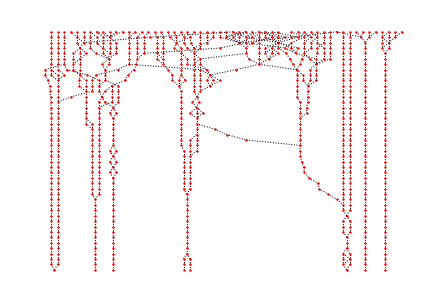

In [12]:
# Might have to call the function multiple times since different connected components might overlap
pos = graphviz_layout(G_ssp, prog="dot", )
nx.draw(G_ssp, pos, node_size=2, node_color='r', font_size=0, style="dotted")

plt.show()